In [174]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter,convolve
import matplotlib.pyplot as plt
from scipy import where
import cv2

/var/folders/nb/91ndyn8522572mnr6hfxzk540000gn/T/ipykernel_5244/2409616582.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter,convolve
/var/folders/nb/91ndyn8522572mnr6hfxzk540000gn/T/ipykernel_5244/2409616582.py:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter,convolve


In [175]:
DPI = 120

### load the image

Text(0.5, 1.0, 'Input image')

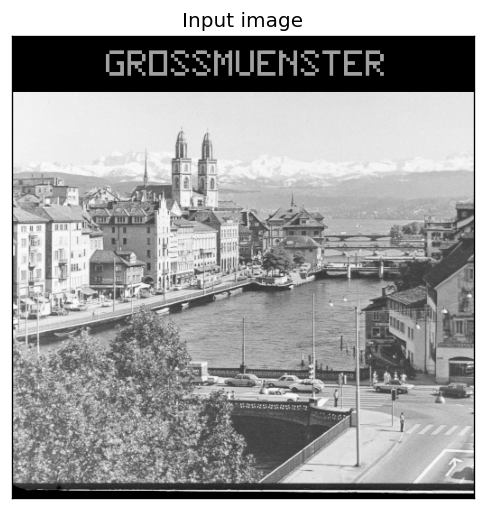

In [176]:
input_img=cv2.imread('inputs/grossmuenster.png', 0).astype('float')
plt.figure(figsize=(5, 5),dpi=DPI)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

### Gaussian blur the image

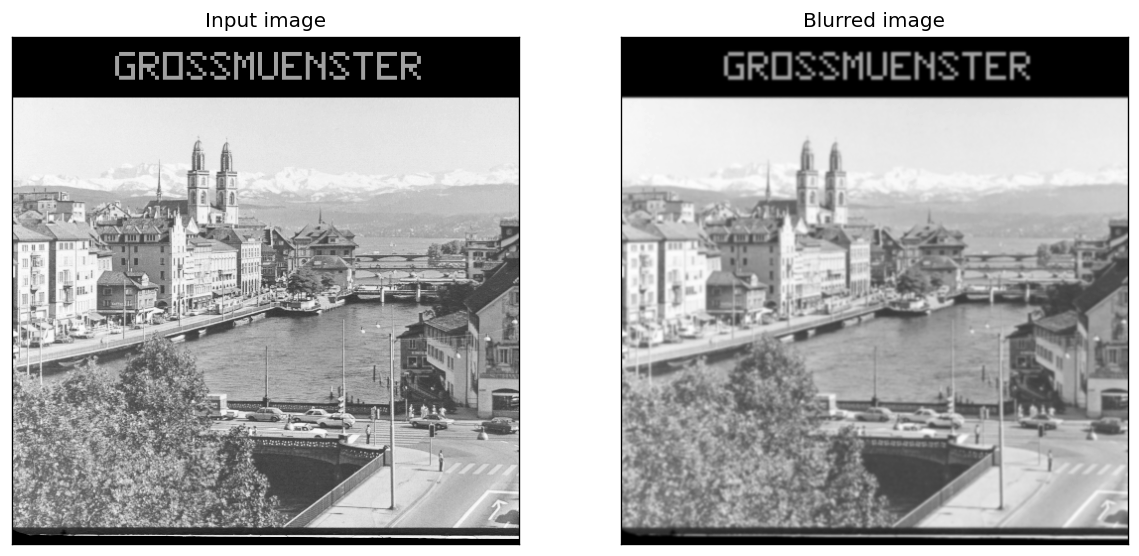

In [177]:
## TODO
blurred_img = gaussian_filter(input_img, sigma=1)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(blurred_img, cmap=plt.cm.gray)
plt.title('Blurred image')
plt.show()

### Use Sobel filter to compute gradient along x and y

In [178]:
## TODO
sobel_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
I_x = convolve(blurred_img, sobel_kernel)
I_y = convolve(blurred_img, sobel_kernel.T)

### Compute gradient magnitude and direction

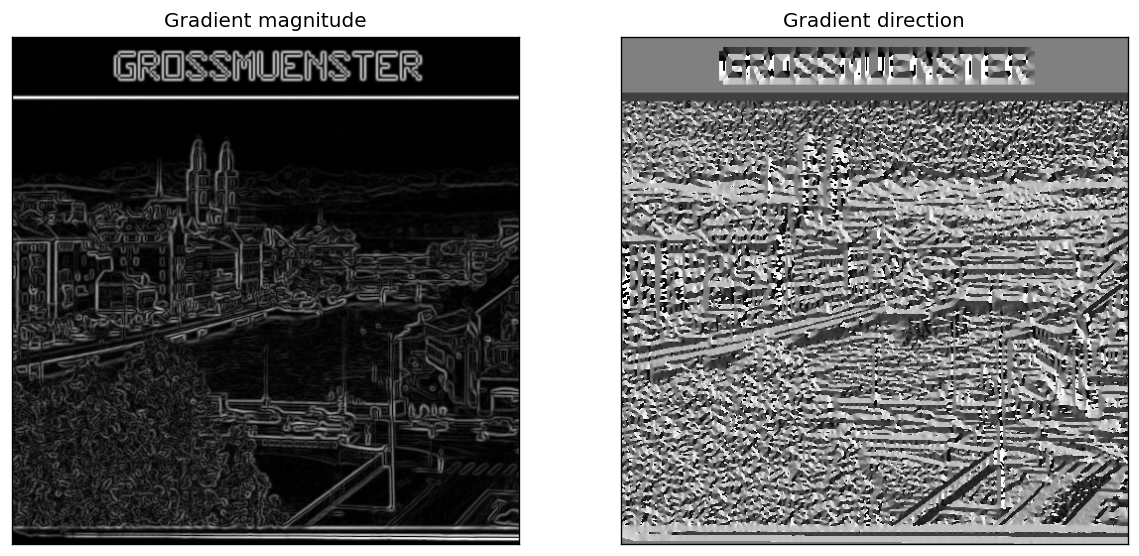

In [179]:
## TODO
magnitude = np.sqrt(I_x**2 + I_y**2)
direction = np.arctan2(I_y, I_x)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(magnitude, cmap = 'gray')
plt.title('Gradient magnitude')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(direction, cmap=plt.cm.gray)
plt.title('Gradient direction')
plt.show()

### Threshold the edges

In [180]:
## TODO
thresh = 0.2 * magnitude.max()
thresholdEdges = (magnitude > thresh)
# mask magnitude with threshold
gradient_threshold = magnitude * thresholdEdges

### Apply NMS

In [181]:
## TODO
def non_max_suppression(gradient, direction):
    M, N = gradient.shape
    output = np.zeros((M,N), dtype=np.int32)
    PI = np.pi

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                # angle 0
                if (0 <= direction[i,j] < PI/8) or (7*PI/8 <= direction[i,j] <= PI): # horizontal
                    q = gradient[i, j+1]
                    r = gradient[i, j-1]
                # angle PI/4
                elif (PI/8 <= direction[i,j] < 3*PI/8): # diagonal leaning right
                    q = gradient[i+1, j-1]
                    r = gradient[i-1, j+1]
                # angle PI/2
                elif (3*PI/8 <= direction[i,j] < 5*PI/8): # vertical
                    q = gradient[i+1, j]
                    r = gradient[i-1, j]
                # angle 3*PI/4
                elif (5*PI/8 <= direction[i,j] < 7*PI/8): # diagonal leaning left
                    q = gradient[i-1, j-1]
                    r = gradient[i+1, j+1]

                if (gradient[i,j] >= q) and (gradient[i,j] >= r):
                    output[i,j] = gradient[i,j] # local maxima
                else:
                    output[i,j] = 0 # non-maxima suppressed

            except IndexError as e:
                pass

    return output

def non_max_suppression_vectorized(gradient, direction):
    PI = np.pi
    M, N = gradient.shape

    # Padding to handle edge cases
    pad_gradient = np.pad(gradient, ((1, 1), (1, 1)), 'constant')
    pad_direction = np.pad(direction, ((1, 1), (1, 1)), 'constant')

    # Prepare the masks for each direction
    horizontal_mask = (0 <= pad_direction) & (pad_direction < PI / 8) | (7 * PI / 8 <= pad_direction) & (pad_direction <= PI)
    right_diagonal_mask = (PI / 8 <= pad_direction) & (pad_direction < 3 * PI / 8)
    vertical_mask = (3 * PI / 8 <= pad_direction) & (pad_direction < 5 * PI / 8)
    left_diagonal_mask = (5 * PI / 8 <= pad_direction) & (pad_direction < 7 * PI / 8)

    # Determine which pixels are local maxima based on their surrounding pixel values
    local_maxima = np.zeros_like(gradient, dtype=bool)
    local_maxima |= horizontal_mask[1:-1,1:-1] & (gradient >= pad_gradient[1:-1, :-2]) & (gradient >= pad_gradient[1:-1, 2:])
    local_maxima |= right_diagonal_mask[1:-1,1:-1] & (gradient >= pad_gradient[:-2, :-2]) & (gradient >= pad_gradient[2:, 2:])
    local_maxima |= vertical_mask[1:-1,1:-1] & (gradient >= pad_gradient[:-2, 1:-1]) & (gradient >= pad_gradient[2:, 1:-1])
    local_maxima |= left_diagonal_mask[1:-1,1:-1] & (gradient >= pad_gradient[:-2, 2:]) & (gradient >= pad_gradient[2:, :-2])

    return np.where(local_maxima, gradient, 0)

edges = non_max_suppression_vectorized(gradient_threshold, direction)

# make it binary
edges[edges > 0] = 255

### Visualise the Canny edges

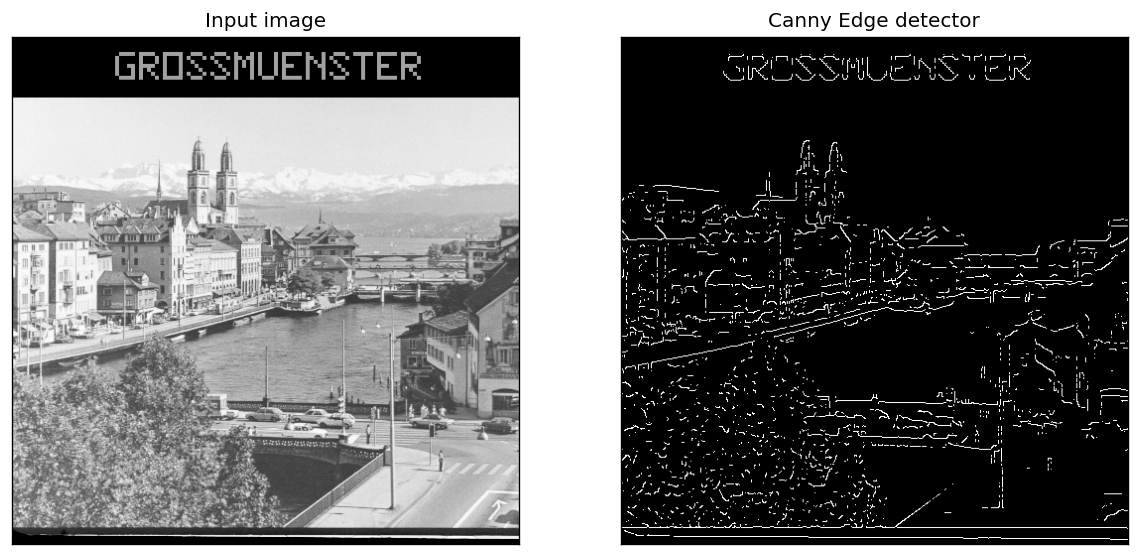

In [182]:
plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(edges, cmap=plt.cm.gray)
plt.title('Canny Edge detector')
plt.show()

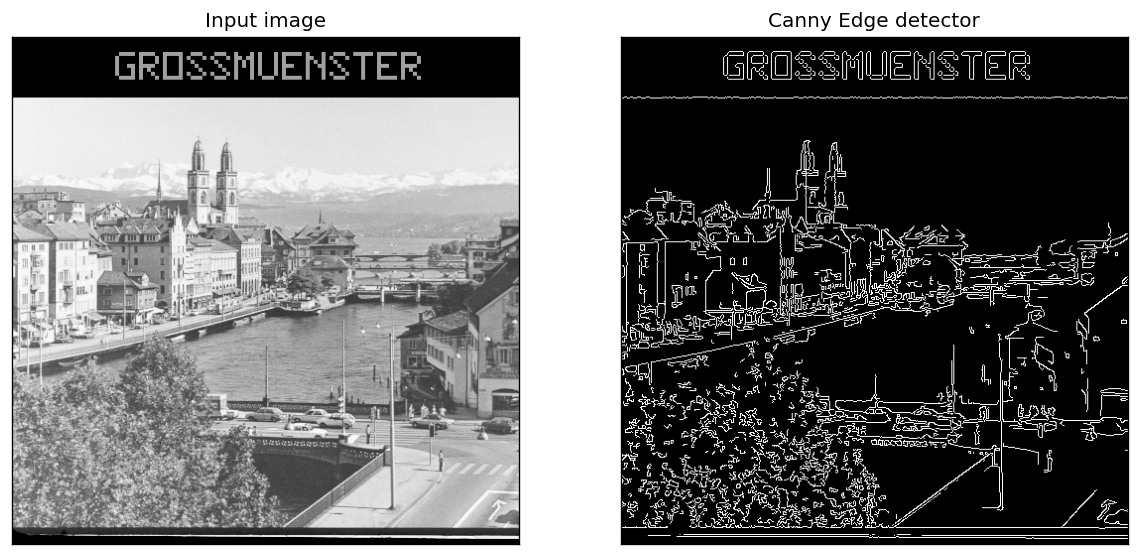

In [189]:
edges_canny = cv2.Canny(input_img.astype('uint8'), 200, 400)

plt.figure(figsize=(12, 12),dpi=DPI)
plt.subplot(121)
plt.xticks([]), plt.yticks([])
plt.imshow(input_img, cmap = 'gray')
plt.title('Input image')

plt.subplot(122)
plt.xticks([]), plt.yticks([])
plt.imshow(edges_canny, cmap=plt.cm.gray)
plt.title('Canny Edge detector')
plt.show()